<H1> PyCaret Unit 6 Assignment </h1>
<h2> By: Ryan Moore </h2>

In [22]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from pycaret.classification import *
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [23]:
# Load data
churn = pd.read_csv("/Users/Ryan/Downloads/Cell Phone Company Churn data-2.csv")


In [24]:
# Preprocess data - Split so target class is Churn
X = churn.drop(['churn', 'state', 'phone number', 'international plan', 'voice mail plan'], axis=1)
y= churn['churn']

# Show target class distribution
class_distribution_initial = Counter(y)


print("Class distribution before SMOTE = " + str(class_distribution_initial))

Class distribution before SMOTE = Counter({False: 2850, True: 483})


In [25]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Show target distribution after SMOTE
class_distribution = Counter(y_train_resampled)

print("Class distribution after SMOTE = " + str(class_distribution))


Class distribution after SMOTE = Counter({False: 2284, True: 2284})


<h3> PyCaret </h3>

In [26]:
#Combine Features and targer into single df
clf = setup(data=X_train_resampled, target = y_train_resampled, train_size=0.8, session_id= 42)

#Compare multiple models
best_models = compare_models(include=['lr', 'rf', 'xgboost', 'lightgbm', 'svm'], n_select=5)
 
# Create a list to store results
results = []



,Description,Value
0,Session id,42
1,Target,churn
2,Target type,Binary
3,Original data shape,"(4568, 17)"
4,Transformed data shape,"(4568, 17)"
5,Transformed train set shape,"(3654, 17)"
6,Transformed test set shape,"(914, 17)"
7,Numeric features,16
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9302,0.9789,0.9124,0.9463,0.9290,0.8604,0.8611,0.3490
xgboost,Extreme Gradient Boosting,0.9228,0.9765,0.9217,0.9241,0.9227,0.8457,0.8460,0.3100
lightgbm,Light Gradient Boosting Machine,0.9187,0.9740,0.9080,0.9282,0.9178,0.8374,0.8380,0.6440
lr,Logistic Regression,0.6937,0.7534,0.7126,0.6871,0.6993,0.3875,0.3881,1.0290
svm,SVM - Linear Kernel,0.5714,0.7146,0.5787,0.5659,0.5061,0.1435,0.1868,0.0130


In [27]:
# Evaluate each model
for model in best_models:
    # Get the model name
    model_name = model.__class__.__name__
    
    # Make predictions on test data
    predictions = predict_model(model, data=X_test)
    
    # Calculate confusion matrix and unpack the values
    cm = confusion_matrix(y_test, predictions['prediction_label'])
    tn, fp, fn, tp = cm.ravel()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, predictions['prediction_label'])
    balanced_acc = balanced_accuracy_score(y_test, predictions['prediction_label'])
    
    # Calculate the model's overall Sensitivity (for the positive class)
    # This is the True Positive Rate
    avg_sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    # Calculate the model's overall Specificity (for the negative class)
    # This is the True Negative Rate
    avg_specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    # Store results
    results.append({
        'Model': model_name,
        'Accuracy': accuracy,
        'Balanced Accuracy': balanced_acc,
        'Avg Sensitivity': avg_sensitivity,
        'Avg Specificity': avg_specificity
    })
 
# Convert results to a DataFrame and display
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False, float_format='{:.4f}'.format))


                 Model  Accuracy  Balanced Accuracy  Avg Sensitivity  Avg Specificity
RandomForestClassifier    0.8981             0.7813           0.6139           0.9488
         XGBClassifier    0.8981             0.7935           0.6436           0.9435
        LGBMClassifier    0.9010             0.8034           0.6634           0.9435
    LogisticRegression    0.6987             0.7045           0.7129           0.6961
         SGDClassifier    0.8486             0.5000           0.0000           1.0000


<h3> Unit 5 Ensemble Mode </h3>

In [28]:
#unit 5 Essemble
def evaluate_model(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    accuracy = accuracy_score(y_true, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_true, y_pred)
    return sensitivity, specificity, accuracy, balanced_accuracy

# Random Forest (Bagging approach)
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, class_weight={0: 1, 1: 5}, random_state=42)
rf_clf.fit(X_train_resampled, y_train_resampled)
rf_pred = rf_clf.predict(X_test)
rf_results = evaluate_model(y_test, rf_pred)

# Gradient Boosting (Boosting approach)
gb_clf = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.01, max_depth = 10, random_state=42)
gb_clf.fit(X_train_resampled, y_train_resampled)
gb_pred = gb_clf.predict(X_test)
gb_results = evaluate_model(y_test, gb_pred)

# Stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=200, max_depth=10, class_weight = {0: 1, 1: 5}, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=1000, learning_rate= 0.01, max_depth=10, random_state=42)),
    ('dt', DecisionTreeClassifier(random_state=42))
]
stacking_clf = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)

stacking_clf.fit(X_train_resampled, y_train_resampled)
stacking_pred = stacking_clf.predict(X_test)
stacking_results = evaluate_model(y_test, stacking_pred)

# Print results
print("\nRandom Forest Results:")
print(f"Sensitivity: {rf_results[0]:.4f}")
print(f"Specificity: {rf_results[1]:.4f}")
print(f"Accuracy: {rf_results[2]:.4f}")
print(f"Balanced Accuracy: {rf_results[3]:.4f}")
print("\nGradient Boosting Results:")
print(f"Sensitivity: {gb_results[0]:.4f}")
print(f"Specificity: {gb_results[1]:.4f}")
print(f"Accuracy: {gb_results[2]:.4f}")
print(f"Balanced Accuracy: {gb_results[3]:.4f}")
print("\nStacking Results:")
print(f"Sensitivity: {stacking_results[0]:.4f}")
print(f"Specificity: {stacking_results[1]:.4f}")
print(f"Accuracy: {stacking_results[2]:.4f}")
print(f"Balanced Accuracy: {stacking_results[3]:.4f}")




Random Forest Results:
Sensitivity: 0.7525
Specificity: 0.6590
Accuracy: 0.6732
Balanced Accuracy: 0.7057

Gradient Boosting Results:
Sensitivity: 0.6436
Specificity: 0.9505
Accuracy: 0.9040
Balanced Accuracy: 0.7970

Stacking Results:
Sensitivity: 0.6337
Specificity: 0.9435
Accuracy: 0.8966
Balanced Accuracy: 0.7886


In [29]:
# Create a DataFrame for the ensemble models
ensemble_results = pd.DataFrame([
    {
        'Model': 'RandomForestClassifier (Ensemble)',
        'Accuracy': rf_results[2],
        'Balanced Accuracy': rf_results[3],
        'Avg Sensitivity': rf_results[0],
        'Avg Specificity': rf_results[1]
    },
    {
        'Model': 'GradientBoostingClassifier (Ensemble)',
        'Accuracy': gb_results[2],
        'Balanced Accuracy': gb_results[3],
        'Avg Sensitivity': gb_results[0],
        'Avg Specificity': gb_results[1]
    },
    {
        'Model': 'StackingClassifier (Ensemble)',
        'Accuracy': stacking_results[2],
        'Balanced Accuracy': stacking_results[3],
        'Avg Sensitivity': stacking_results[0],
        'Avg Specificity': stacking_results[1]
    }
])

# Concatenate the PyCaret results and the ensemble results
final_results_df = pd.concat([results_df, ensemble_results], ignore_index=True)

# Print the combined DataFrame
print(final_results_df.to_string(index=False, float_format='{:.4f}'.format))


                                Model  Accuracy  Balanced Accuracy  Avg Sensitivity  Avg Specificity
               RandomForestClassifier    0.8981             0.7813           0.6139           0.9488
                        XGBClassifier    0.8981             0.7935           0.6436           0.9435
                       LGBMClassifier    0.9010             0.8034           0.6634           0.9435
                   LogisticRegression    0.6987             0.7045           0.7129           0.6961
                        SGDClassifier    0.8486             0.5000           0.0000           1.0000
    RandomForestClassifier (Ensemble)    0.6732             0.7057           0.7525           0.6590
GradientBoostingClassifier (Ensemble)    0.9040             0.7970           0.6436           0.9505
        StackingClassifier (Ensemble)    0.8966             0.7886           0.6337           0.9435


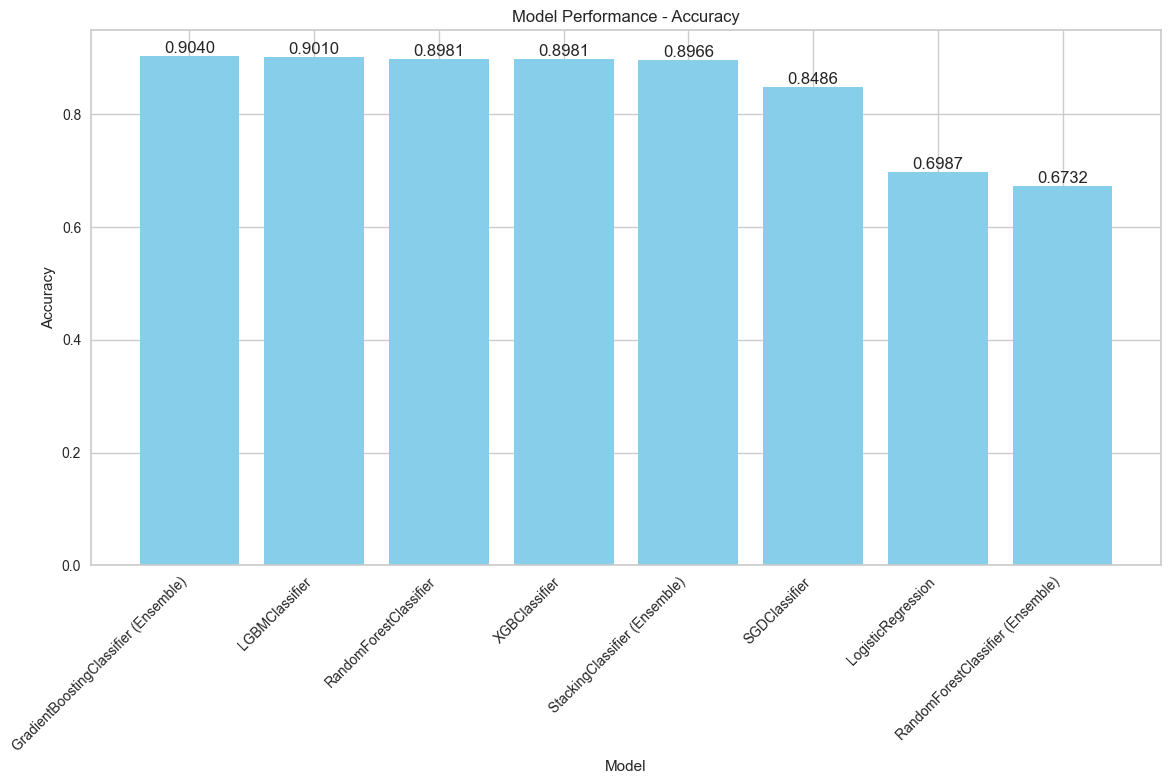

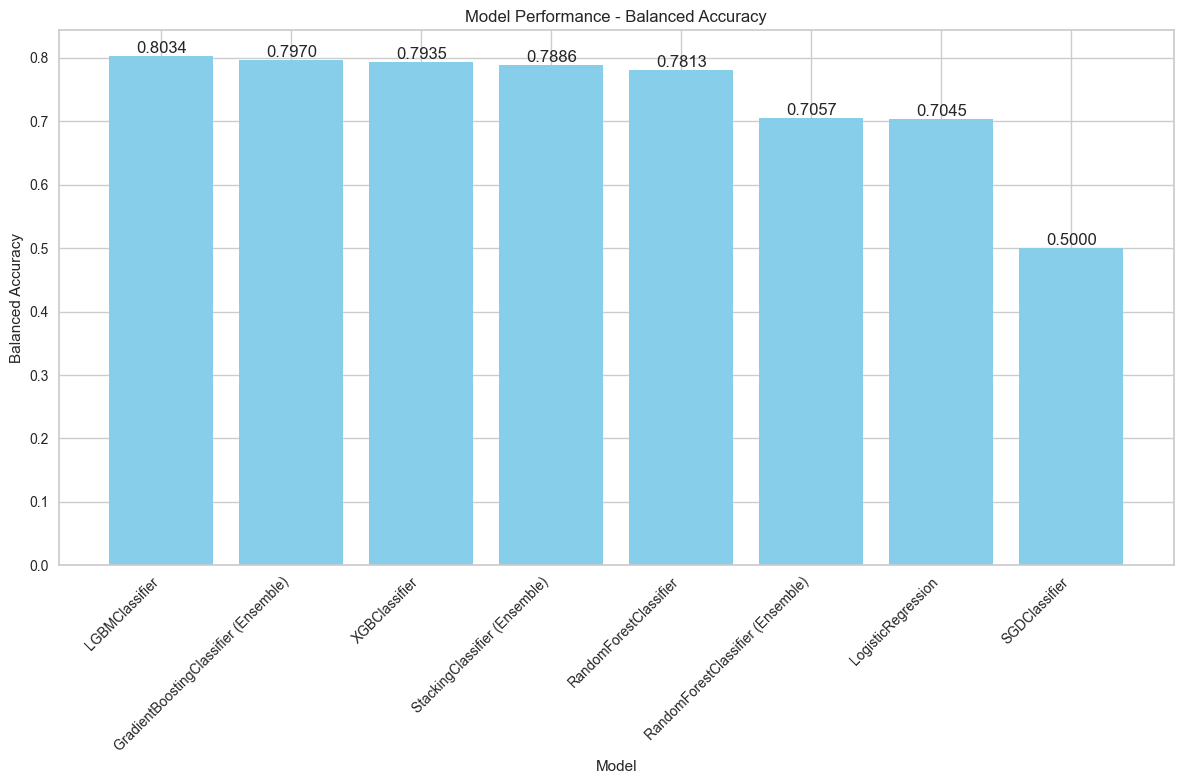

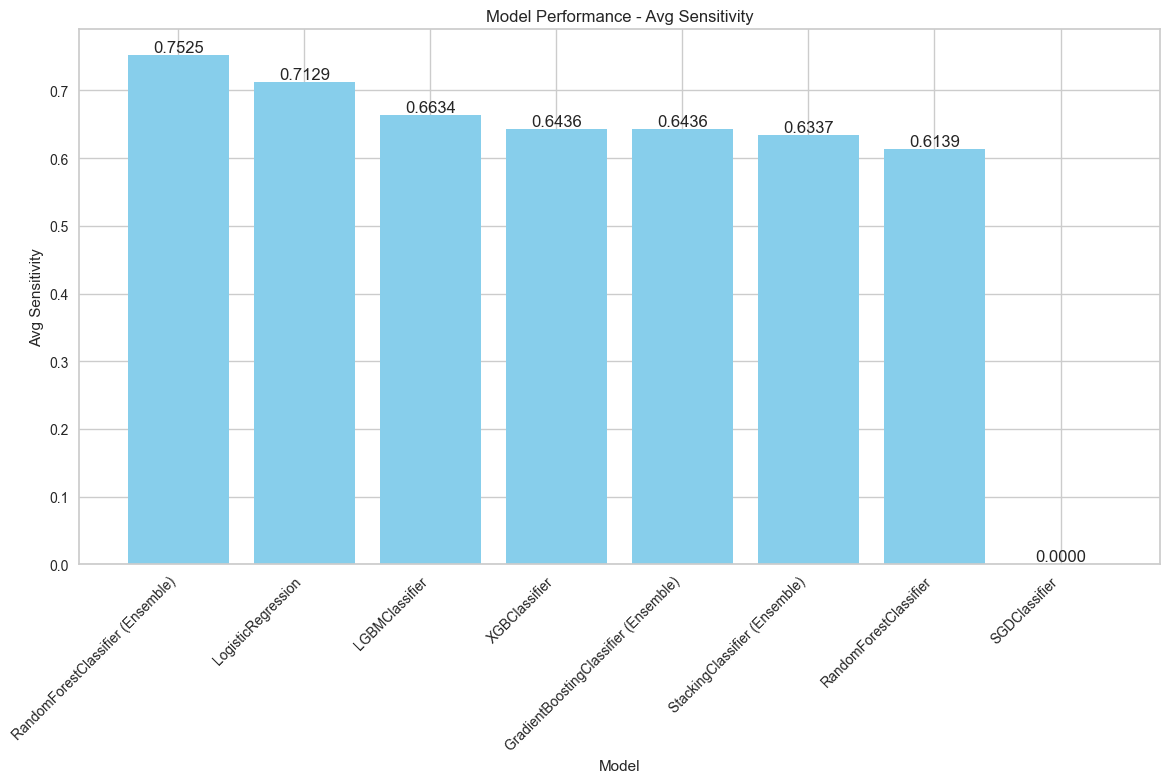

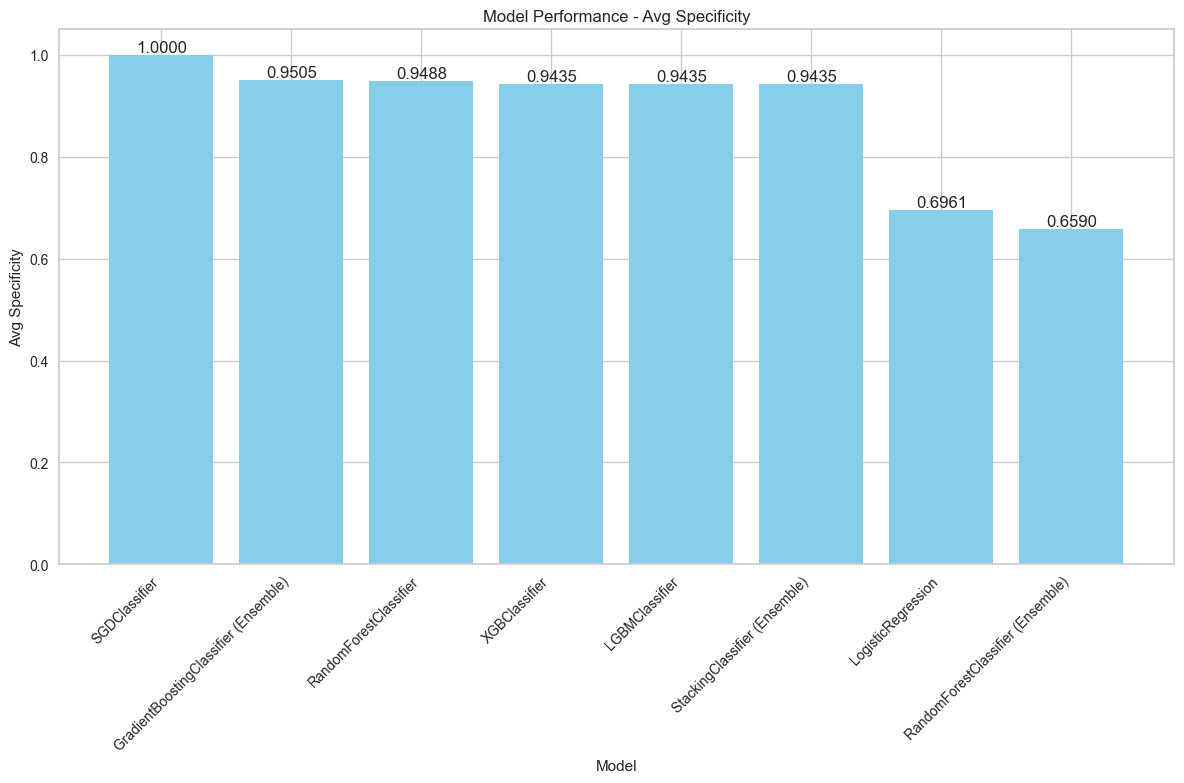

In [30]:
# Generate and save bar charts for each metric
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Balanced Accuracy', 'Avg Sensitivity', 'Avg Specificity']

for metric in metrics:
    plt.figure(figsize=(12, 8))
    sorted_df = final_results_df.sort_values(by=metric, ascending=False)
    plt.bar(sorted_df['Model'], sorted_df[metric], color='skyblue')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.title(f'Model Performance - {metric}')
    plt.xticks(rotation=45, ha='right')
    
    # Add values on top of the bars
    for index, value in enumerate(sorted_df[metric]):
        plt.text(index, value, f'{value:.4f}', ha='center', va='bottom')
        
    plt.tight_layout()
    plt.savefig(f'{metric.lower().replace(" ", "_")}_bar_chart_with_values.png')
    plt.show()
